# 插补点评估

在CNC插补中，对于给定的G01点，插补算法生成了一系列插补点。

怎么从运动学性质、轨迹的几何性质刻画插补轨迹的多个衡量指标？

In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(osp.abspath("")).parents[0]
sys.path.append(str(root_path))

%config InlineBackend.figure_format='retina'

生成插补点

In [2]:
from papers.Zhao2013.algorithm import SmoothedPath
import numpy as np
import utils.visualization as vis
from core.look_ahead import BidirectionalScanner
from core.feedrate_scheduler import FeedrateScheduler
from core.interpolator import Interpolator

data_name = "rhombic"
Ts = 0.0005
V_MAX = 100
A_MAX = 3000
J_MAX = 60000
chord_error = 0.2

g01_points = np.array([[2, 0], [4, 2], [2, 4], [0, 2], [2, 0]])
smooth_path = SmoothedPath(g01_points, chord_error)
scanner_smooth = BidirectionalScanner(smooth_path, Ts, V_MAX, A_MAX, J_MAX)
v_lim_smooth = scanner_smooth.v_limit
smooth_path_lengths = smooth_path.lengths
smooth_scheduler = FeedrateScheduler(smooth_path_lengths, v_lim_smooth, V_MAX, A_MAX, J_MAX, Ts)
smooth_profiles = smooth_scheduler.profiles
smooth_interpolator = Interpolator(smooth_path, smooth_scheduler, Ts)
smooth_interpolated_points = smooth_interpolator.interpolate()
print(f"Total time: {smooth_scheduler.total_time}")

interp_data = smooth_interpolator.data
np.save(f"../experiments/output/{data_name}_interp_data.npy", interp_data)

Total time: 0.3685074310957597


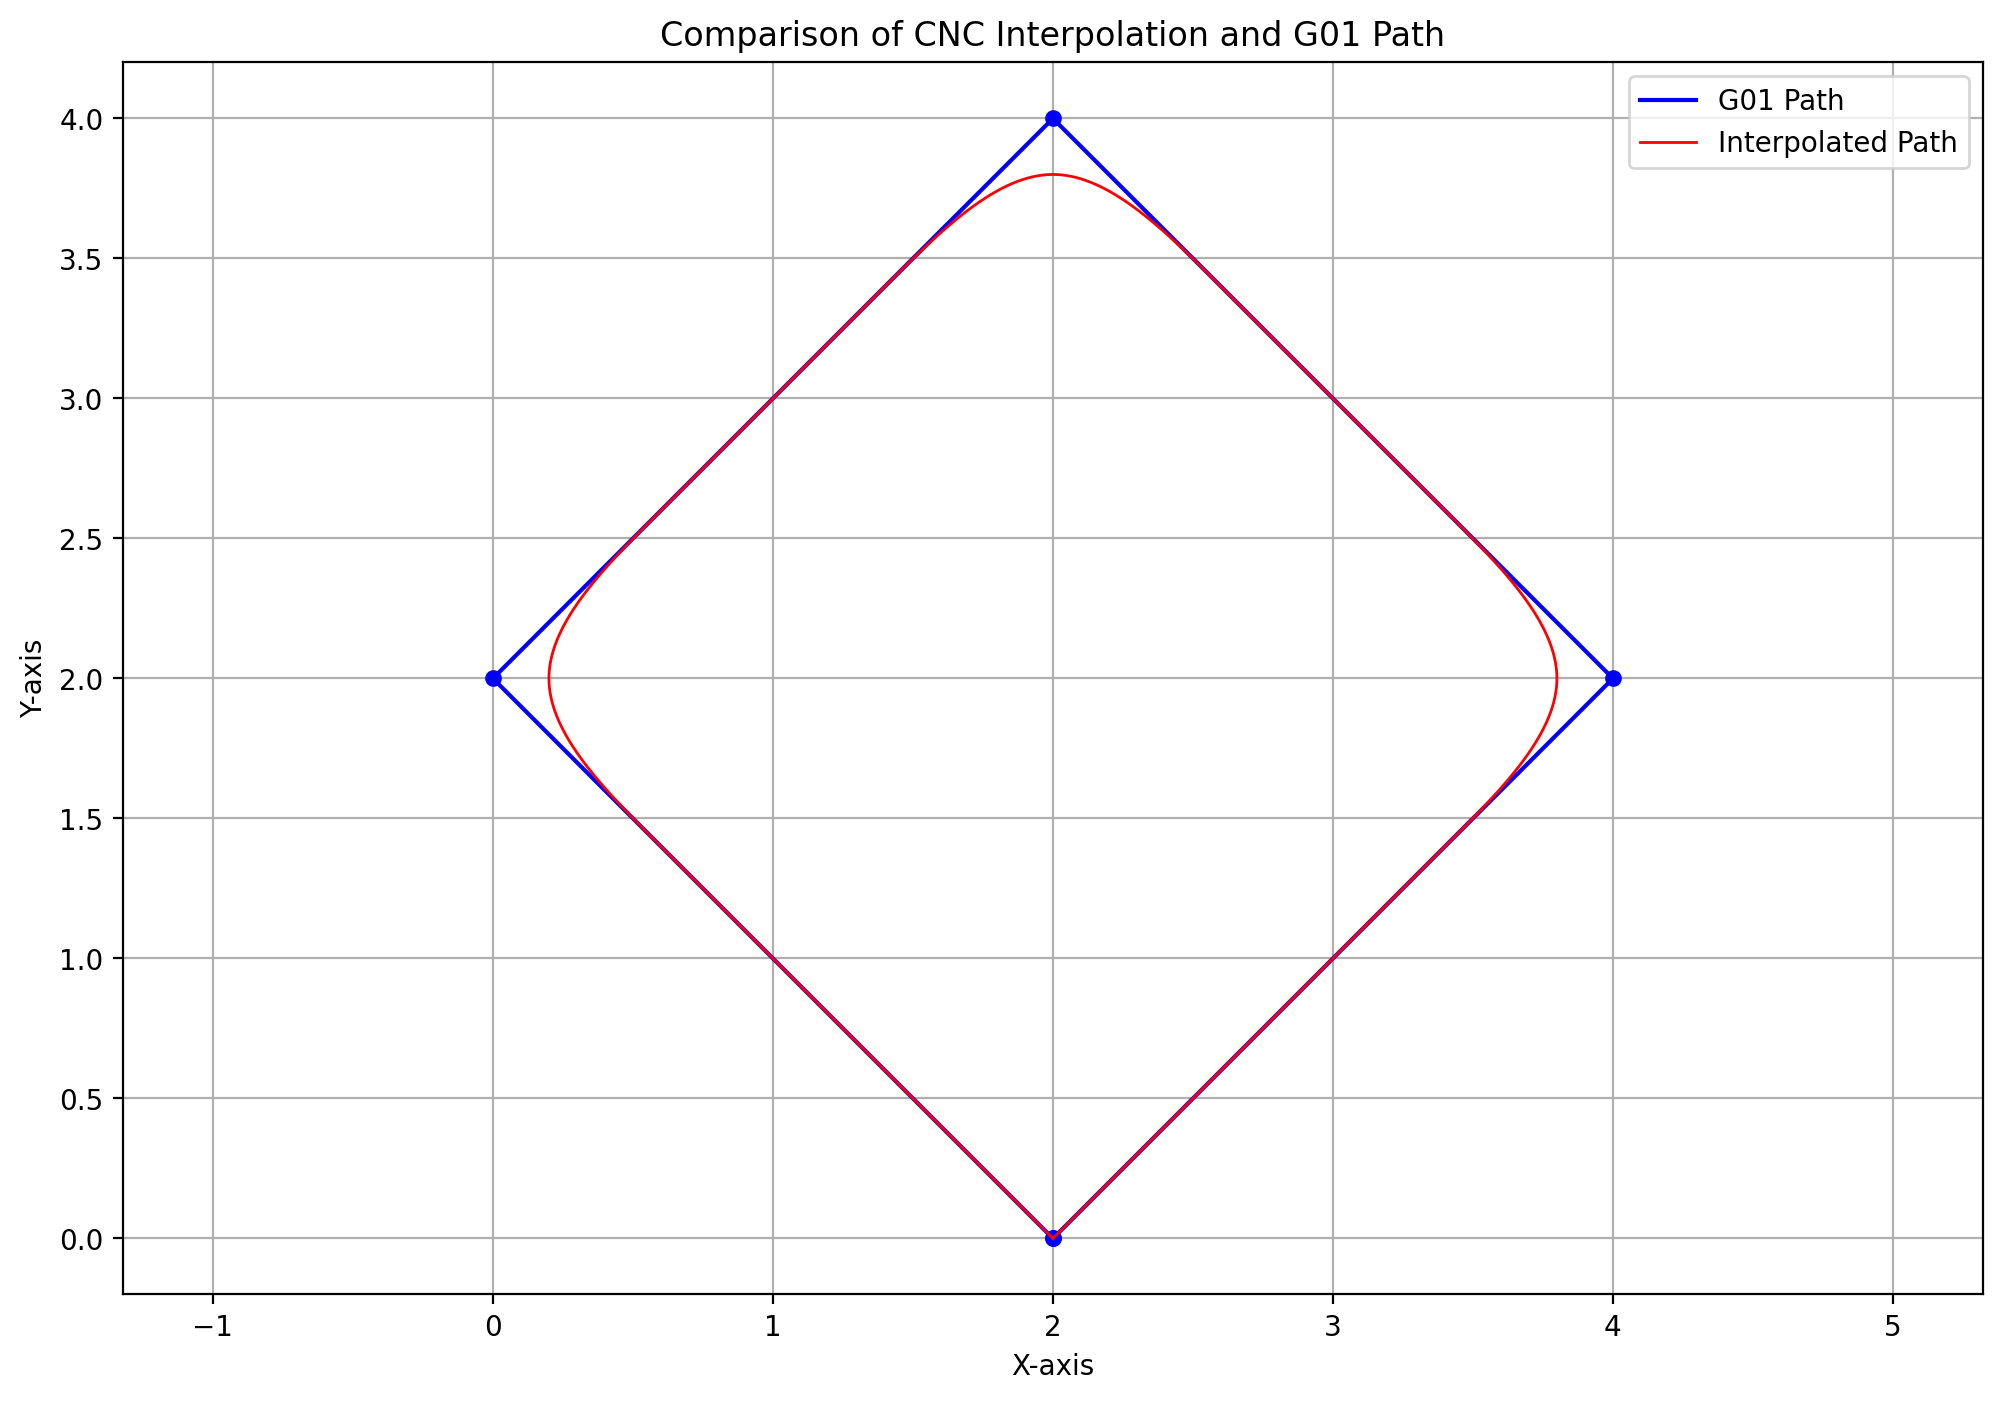

In [3]:
from metrics.eval import (
    compute_path_deviation,
    compute_chordal_height_error,
    compute_curvature,
    compute_direction_changes,
    visualize,
    compute_rms,
)

interp_data = np.load(f"../experiments/output/{data_name}_interp_data.npy", allow_pickle=True)
interpolated_points = interp_data["P"]
T, V, A, J, D = interp_data["T"], interp_data["V"], interp_data["A"], interp_data["J"], interp_data["D"]
visualize(g01_points, interpolated_points)

## 1. 插补轨迹的几何精度

### 1.1 **路径偏差**（Path Deviation）

路径偏差衡量插补点生成的轨迹与原始G01线段之间的偏差，反映插补轨迹对原始路径的跟踪精度。

**计算方法：**

对于每个插补点，计算其到G01线段最近点的距离，作为路径偏差。

**计算公式：**

设插补点为 $\mathbf{p}_i$，G01线段的起点为 $\mathbf{a}$，终点为 $\mathbf{b}$。计算插补点 $\mathbf{p}_i$ 到 G01 线段最近点的公式如下：

1. 计算投影参数 $ t $ 并进行截断：
   $$
   t = \frac{(\mathbf{p}_i - \mathbf{a})^\top (\mathbf{b} - \mathbf{a})}{(\mathbf{b} - \mathbf{a})^\top (\mathbf{b} - \mathbf{a})}
   $$
   截断 $ t $ 使其在 $[0, 1]$ 范围内：
   $$
   t = \max(0, \min(1, t))
   $$

2. 计算最近点 $\mathbf{p}_{\text{closest}}$：
   $$
   \mathbf{p}_{\text{closest}} = \mathbf{a} + t (\mathbf{b} - \mathbf{a})
   $$

3. 计算距离 $\Delta d_i$：
   $$
   \Delta d_i = \left\| \mathbf{p}_i - \mathbf{p}_{\text{closest}} \right\|
   $$

**指标：**

- 平均偏差：$\frac{1}{N}\sum_{i=1}^N \Delta d_i$
- 最大偏差：$\max_{i=1}^N \Delta d_i$


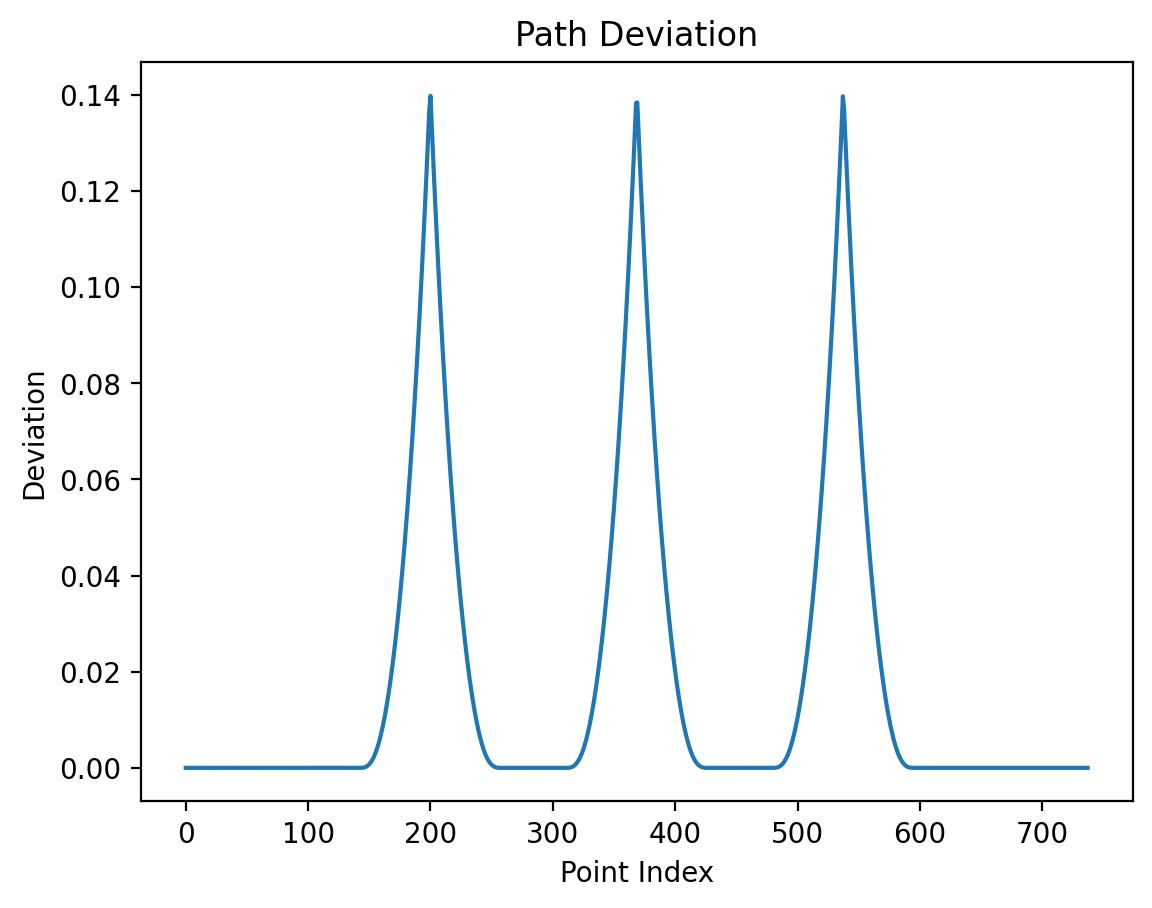

Average path deviation: 0.018997249232064632
Maximum path deviation: 0.1397691325242502


In [4]:
deviation_vectors, distances = compute_path_deviation(g01_points, interpolated_points)

plt.plot(distances)
plt.title("Path Deviation")
plt.xlabel("Point Index")
plt.ylabel("Deviation")
plt.show()

print(f"Average path deviation: {np.mean(distances)}")
print(f"Maximum path deviation: {np.max(distances)}")

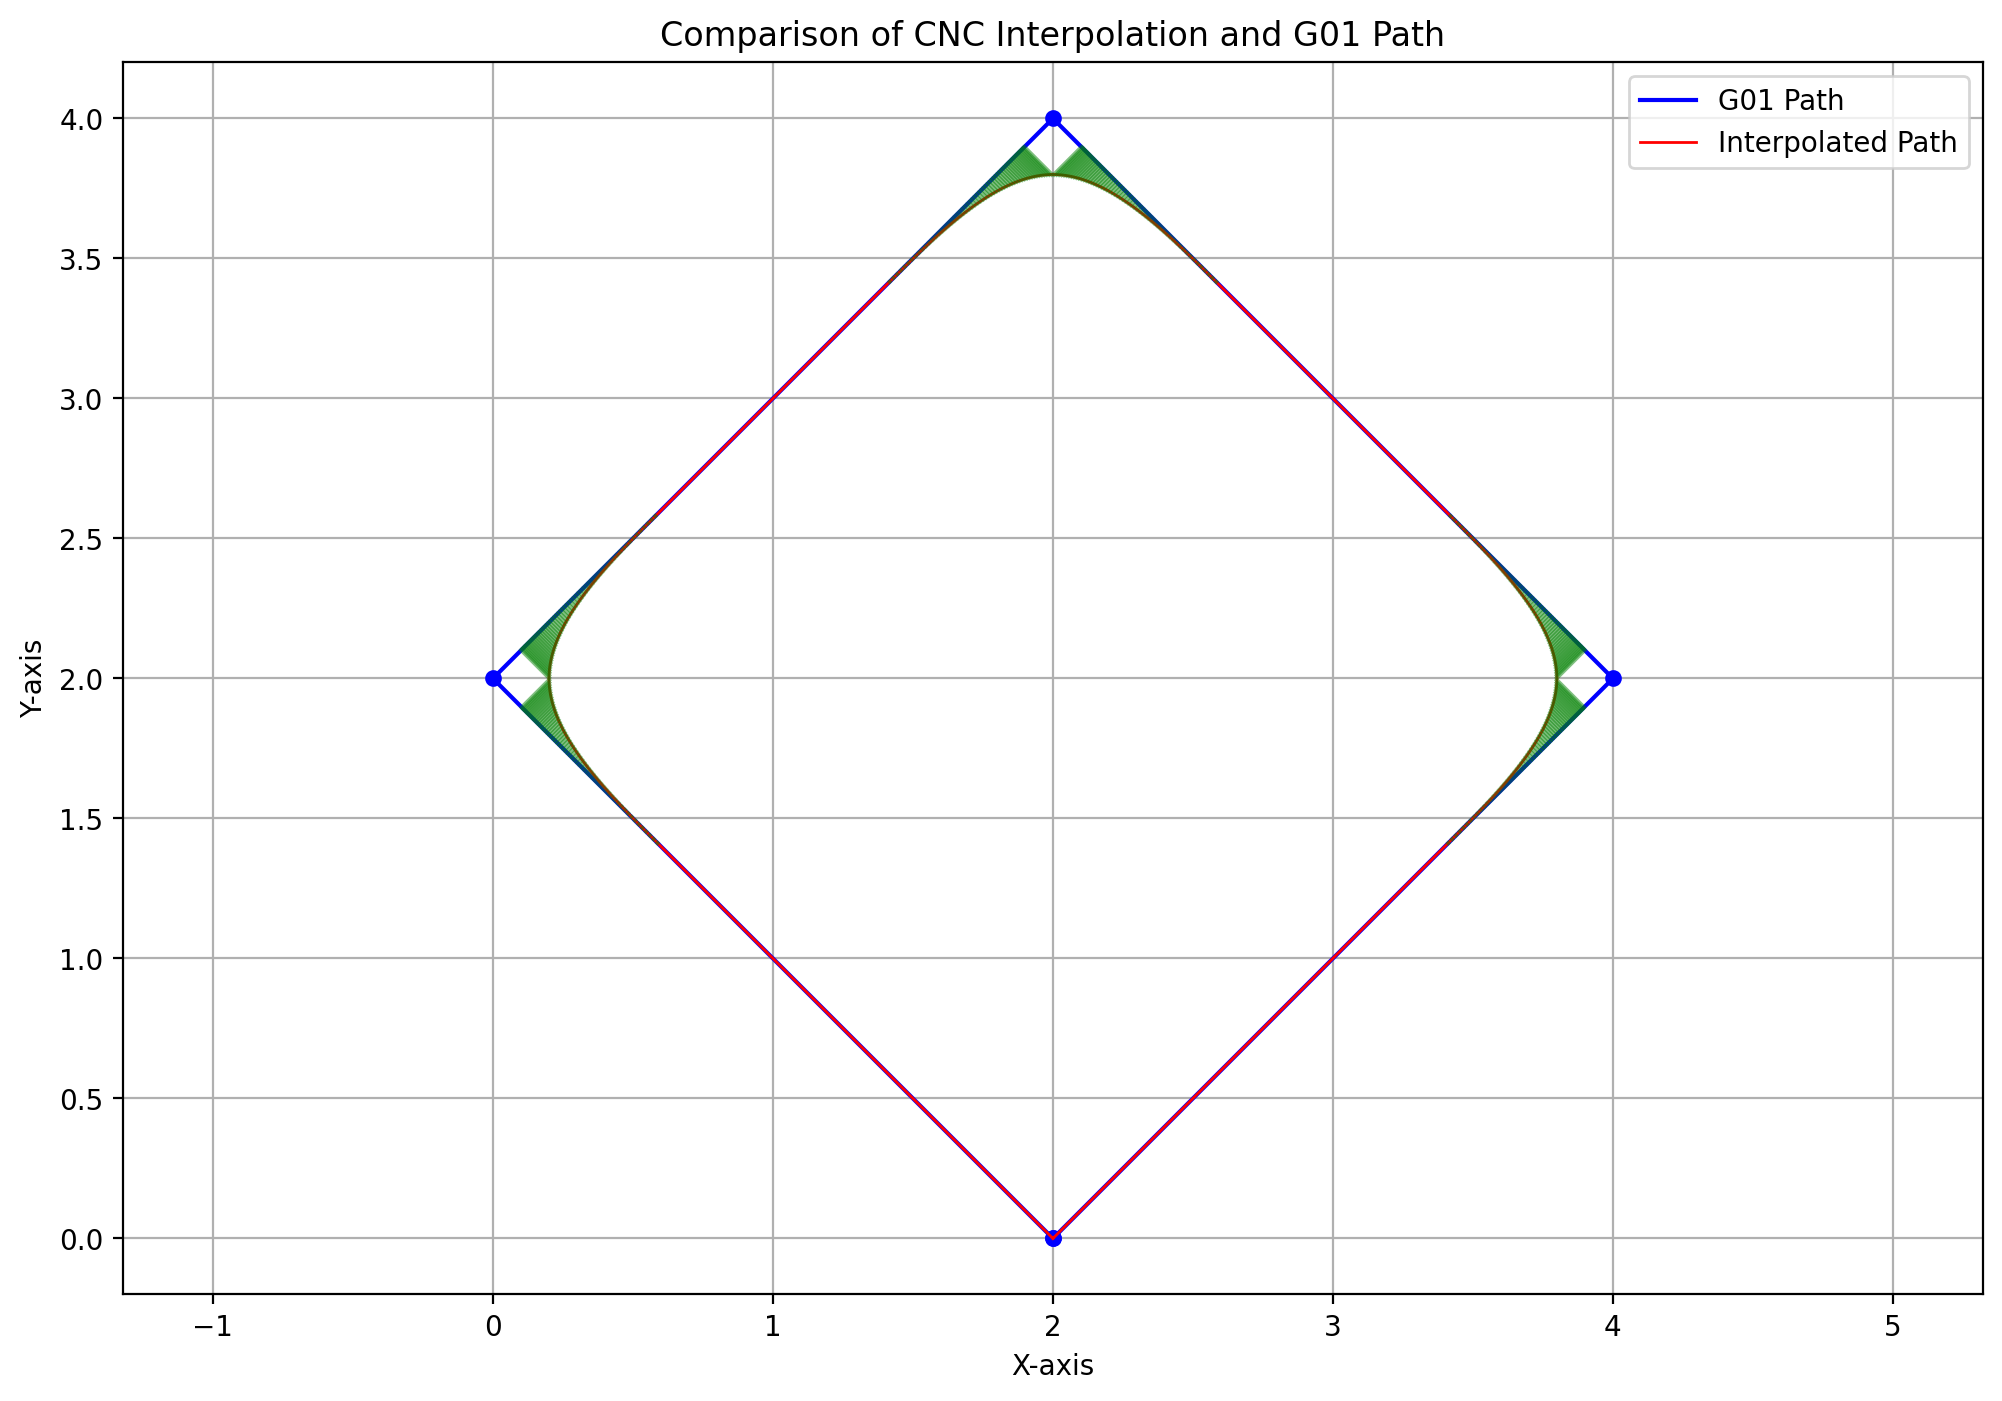

In [5]:
visualize(g01_points, interpolated_points, -deviation_vectors)

### 1.2 **弦高误差**（Chordal Height Error）

表示插补点生成的轨迹与原始G01点连接的弦之间的偏差，反映插补轨迹的平滑性。

**计算方法：**

对于所有G01点，计算每个点到所有插补点路径的距离。

**计算公式：**

对于每一个G01点$\mathbf{g}_i$，找到距离其最近的插补点$\mathbf{p}_j$。弦高误差$\Delta h_i$表示为：
$$
\Delta h_i = \min_j |\mathbf{g}_i - \mathbf{p}_j|
$$

**指标：**

- 平均弦高误差：$\frac{1}{N}\sum_{i=1}^N \Delta h_i$
- 最大弦高误差：$\max_{i=1}^N \Delta h_i$

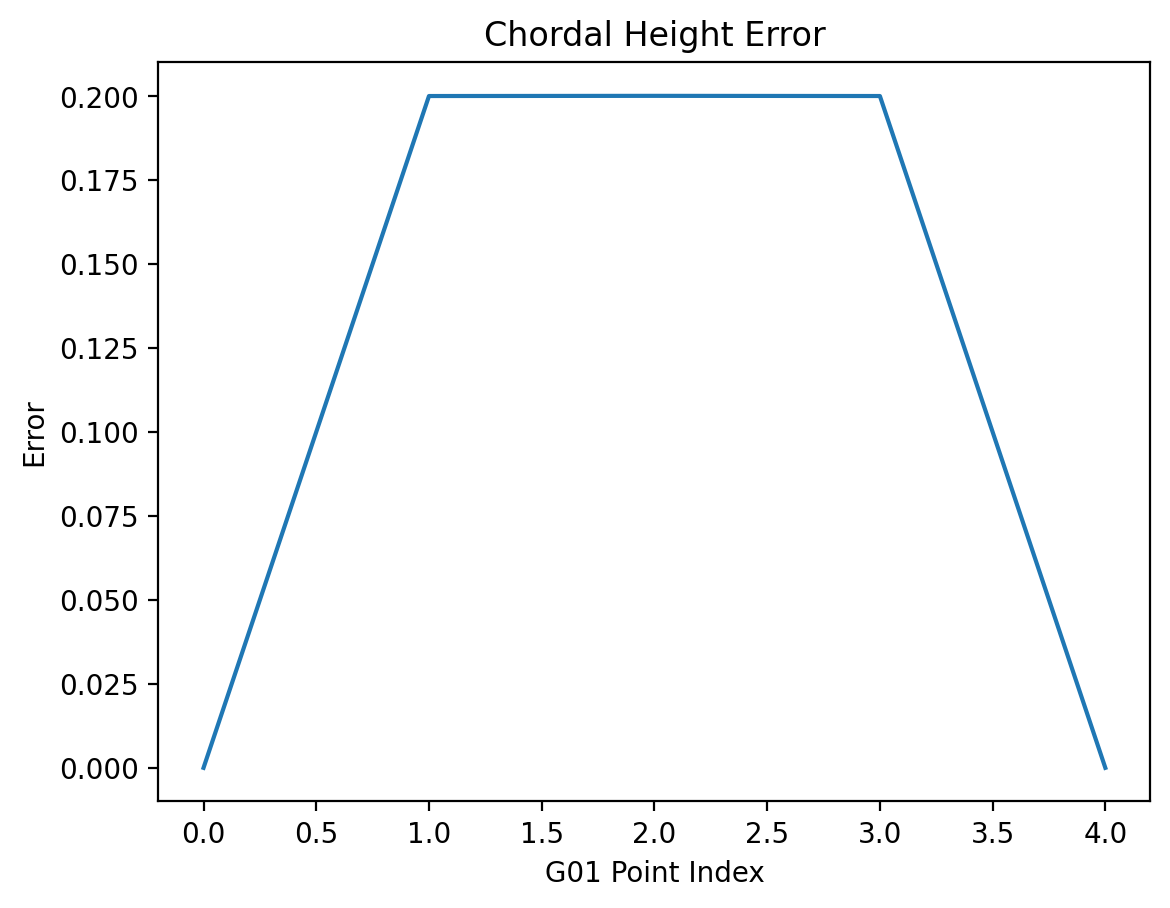

Average chordal height error: 0.120025079089539
Maximum chordal height error: 0.20007752513802318


In [6]:
errors = compute_chordal_height_error(g01_points, interpolated_points)

plt.plot(errors)
plt.title("Chordal Height Error")
plt.xlabel("G01 Point Index")
plt.ylabel("Error")
plt.show()

print(f"Average chordal height error: {np.mean(errors)}")
print(f"Maximum chordal height error: {np.max(errors)}")

## 2. 插补轨迹的平滑性

### 2.1 曲率

表示插补点生成的轨迹的弯曲程度，反映插补轨迹的平滑性。

**计算方法：**

对于离散点序列中的第 $i$ 个点，其曲率$\kappa_i$可以用以下公式表示：
$$
\kappa_i = \frac{2 \cdot \left\| (\mathbf{p}_{i+1} - \mathbf{p}_i) \times (\mathbf{p}_{i+2} - \mathbf{p}_{i+1}) \right\|}{\left\| \mathbf{p}_{i+1} - \mathbf{p}_i \right\| \cdot \left\| \mathbf{p}_{i+2} - \mathbf{p}_{i+1} \right\| \cdot \left\| \mathbf{p}_{i+2} - \mathbf{p}_i \right\|}
$$

**指标：**

- 平均曲率：$\frac{1}{N-2} \sum_{i=2}^{N-1} \kappa_i$
- 最大曲率：$\max_{i=2}^{N-1} \kappa_i$
- 曲率变化率：计算曲率的变化，$\Delta \kappa_i = \kappa_{i+1} - \kappa_i$

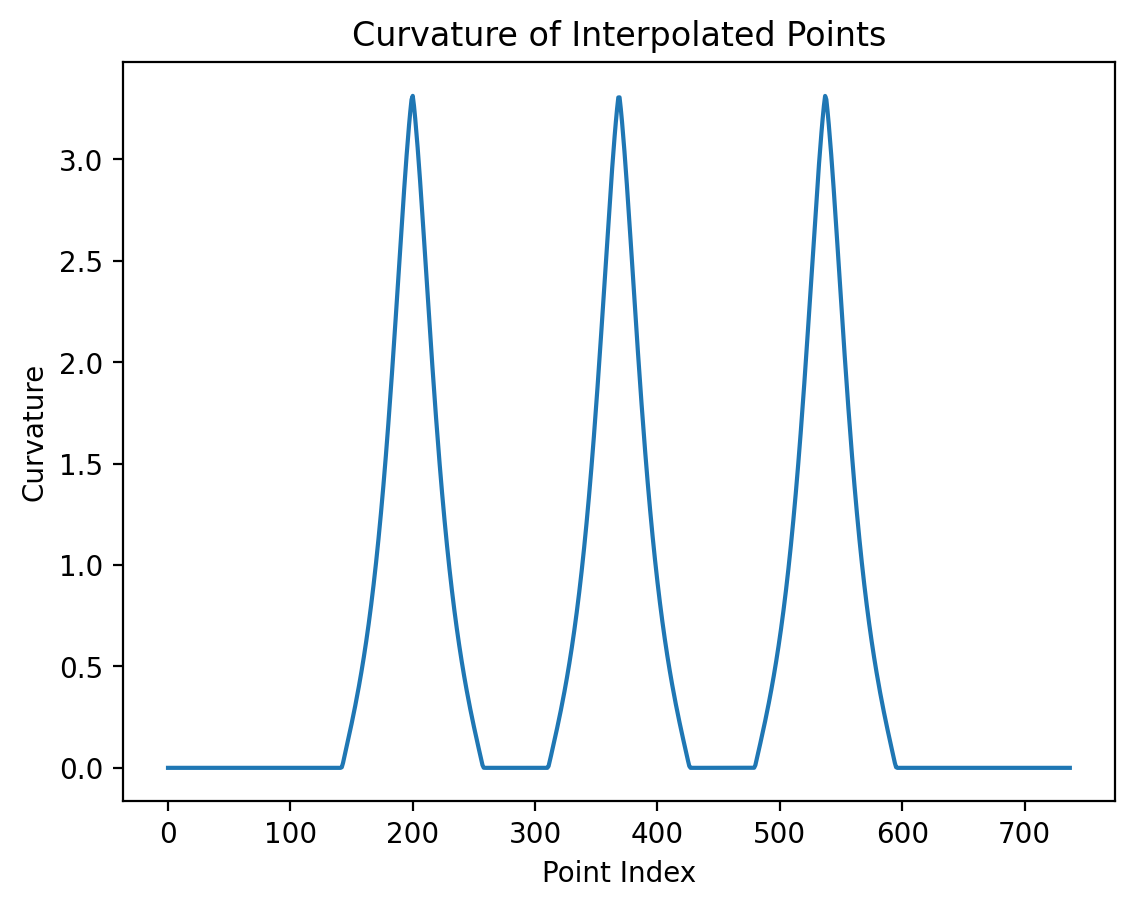

In [7]:
curvatures = compute_curvature(interpolated_points)

plt.plot(curvatures)
plt.title("Curvature of Interpolated Points")
plt.xlabel("Point Index")
plt.ylabel("Curvature")
plt.show()

### 2.2 **曲率连续性**（Curvature Continuity）

评估轨迹曲率在各插补点的连续性。对于轨迹平滑插补，通常希望在插补点处保持二阶甚至更高阶的连续性，来避免不平滑或尖角现象。

**计算方法：**

通过计算相邻插补点的曲率变化，评估曲率连续性。

**指标：**

- 平均曲率变化率：$\frac{1}{N-3} \sum_{i=2}^{N-2} \Delta \kappa_i$
- 最大曲率变化率：$\max_{i=2}^{N-2} \Delta \kappa_i$

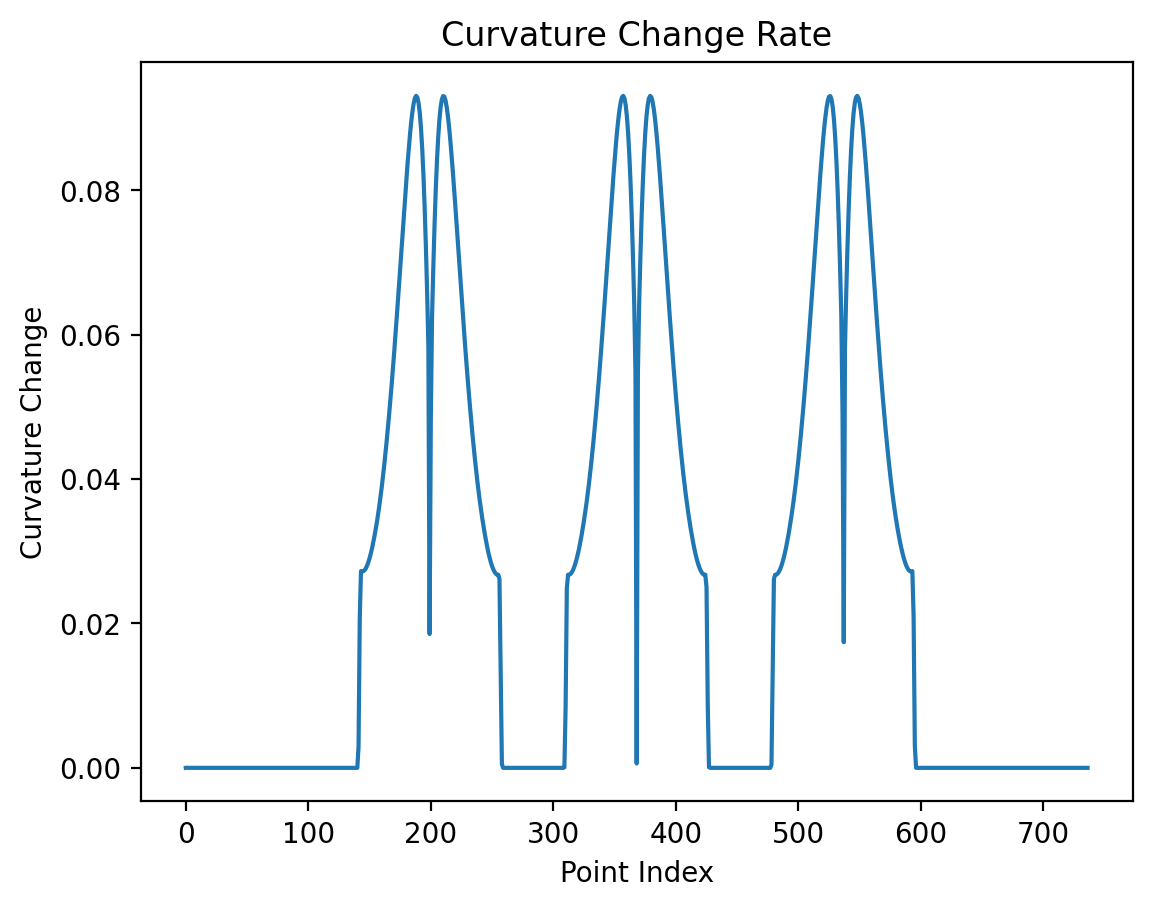

In [8]:
delta_curvatures = np.diff(curvatures)

plt.plot(np.abs(delta_curvatures))
plt.title("Curvature Change Rate")
plt.xlabel("Point Index")
plt.ylabel("Curvature Change")
plt.show()

### 2.3 **方向变化率**（Direction Change Rate）

相邻线段之间方向的变化程度可以用方向变化率来衡量。

**计算方法：**

对于每一对连续的线段 $\overline{\mathbf{p}_i \mathbf{p}_{i+1}}$ 和 $\overline{\mathbf{p}_{i+1} \mathbf{p}_{i+2}}$，计算它们之间的夹角 $\Delta\theta_i$，并统计所有 $\Delta\theta_i$ 的平均值、标准差、最大值等。

**简化后的计算公式：**

设插补点序列为 $\{\mathbf{p}_1, \mathbf{p}_2, \ldots, \mathbf{p}_N\}$，计算相邻线段方向变化率的步骤如下：

1. 计算相邻点之间的向量：
   $$
   \mathbf{v}_i = \mathbf{p}_{i+1} - \mathbf{p}_i \quad \text{for} \quad i = 1, 2, \ldots, N-1
   $$

2. 计算相邻向量的夹角：
   $$
   \Delta\theta_i = \arccos\left( \frac{\mathbf{v}_i \cdot \mathbf{v}_{i+1}}{\|\mathbf{v}_i\| \|\mathbf{v}_{i+1}\|} \right) \quad \text{for} \quad i = 1, 2, \ldots, N-2
   $$

**指标：**

- 平均方向变化率：$\frac{1}{N-2}\sum_{i=1}^{N-2} \Delta\theta_i$
- 最大方向变化率：$\max_{i=1}^{N-2} \Delta\theta_i$

In [9]:
direction_changes = compute_direction_changes(interpolated_points)

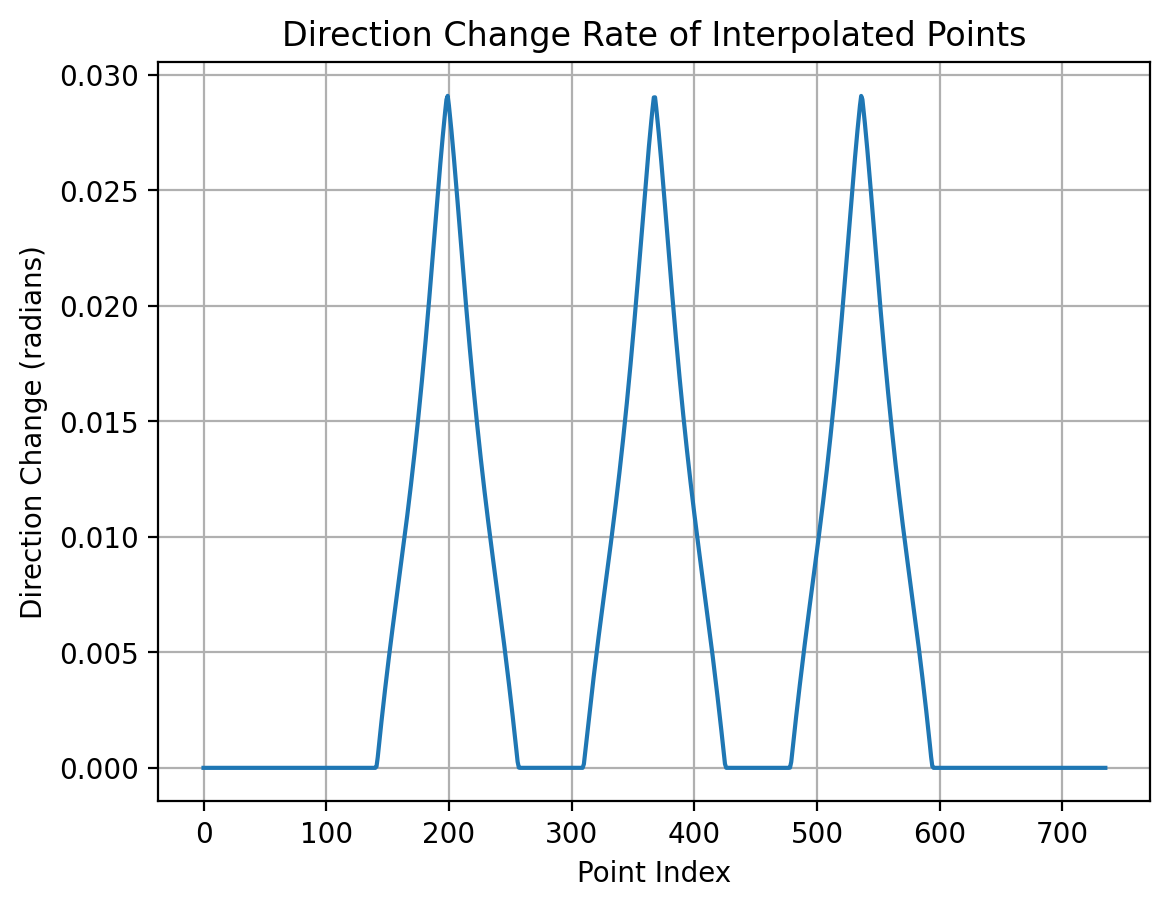

Average direction change rate: 0.0064 radians
Maximum direction change rate: 0.0291 radians


In [10]:
plt.plot(direction_changes)
plt.title("Direction Change Rate of Interpolated Points")
plt.xlabel("Point Index")
plt.ylabel("Direction Change (radians)")
plt.grid(True)
plt.show()

# Calculate statistical indicators
avg_direction_change = np.mean(direction_changes)
max_direction_change = np.max(direction_changes)

print(f"Average direction change rate: {avg_direction_change:.4f} radians")
print(f"Maximum direction change rate: {max_direction_change:.4f} radians")

## 3. 运动学性质

### 3.1 **RMS加速度**（Root Mean Square Acceleration）

通过计算整个轨迹中的加速度均方根值来衡量加速度的波动性。RMS 加速度越小，表示速度变化越平稳。

**计算公式：**

$$
a_{\text{RMS}} = \sqrt{\frac{1}{T} \int_0^T a^2(t) dt}
$$

In [11]:
a_rms = compute_rms(A)
print(f"RMS Acceleration: {a_rms}")

RMS Acceleration: 816.0037146411569


### 3.2 **RMS Jerk**（Root Mean Square Jerk）

类似于 RMS 加速度，RMS Jerk 用于衡量 Jerk 的波动性。RMS Jerk 较小表明速度变化更平稳。

**计算公式：**

$$
j_{\text{RMS}} = \sqrt{\frac{1}{T} \int_0^T j^2(t) dt}
$$

In [12]:
j_rms = compute_rms(J)
print(f"RMS Jerk: {j_rms}")

RMS Jerk: 60000.0


## 4. 插补轨迹的时间性能

### 4.1 **插补时间**（Interpolation Time）

这是生成M个插补点所需的总时间，通常与轨迹的长度、速度和加速度分布有关。优化插补时间有助于提高机床的加工效率。

**指标：**

- 总插补时间：生成所有插补点所需的时间

In [13]:
print(f"Interpolation Time: {T[-1]}")

Interpolation Time: 0.36850000000000027


In [14]:
import pandas as pd

metrics = {
    "平均路径偏差": np.mean(distances),
    "最大路径偏差": np.max(distances),
    "平均弦高误差": np.mean(errors),
    "最大弦高误差": np.max(errors),
    "平均曲率": np.mean(curvatures),
    "最大曲率": np.max(curvatures),
    "平均曲率变化率": np.mean(np.abs(delta_curvatures)),
    "最大曲率变化率": np.max(np.abs(delta_curvatures)),
    "平均方向变化率": np.mean(direction_changes),
    "最大方向变化率": np.max(direction_changes),
    "RMS加速度": a_rms,
    "RMS Jerk": j_rms,
    "插补时间": T[-1],
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=["指标", "数值"])
metrics_df

,指标,数值
0,平均路径偏差,0.018997
1,最大路径偏差,0.139769
2,平均弦高误差,0.120025
3,最大弦高误差,0.200078
4,平均曲率,0.617281
5,最大曲率,3.312915
6,平均曲率变化率,0.026950
7,最大曲率变化率,0.093082
8,平均方向变化率,0.006403
9,最大方向变化率,0.029081
